# Biclustering (with Paul Revere)


ref: http://scikit-learn.org/stable/auto_examples/bicluster/bicluster_newsgroups.html

Biclustering is a helpful clustering procedure that derives cluster membership for both rows and columns. Clustering rows and columns individually is fairly common. I view biclustering as an extension that allows me to ask: "If these columns are clustered together, which rows (if any) point towards that clustering? Accordingly, if any rows are clustered together, which column values might tell me why they're clustered?"

I have found it helpful with:
- Incidence Matrix / Cooccurence data (typically found before converting something into a graph/network structure)
- Text data (the [original paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.140.3011&rep=rep1&type=pdf) on coclustering does this)

The example below performs coclustering on the awesome "Paul Revere dataset" originally analyzed in an [amazing blog post](https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/) by [Kieran Healy](https://kieranhealy.org/).

## References:
> Biclustering algorithms simultaneously cluster rows and columns of a data matrix. These clusters of rows and columns are known as biclusters. Each determines a submatrix of the original data matrix with some desired properties.

[sklearn - Biclustering](http://scikit-learn.org/stable/modules/biclustering.html#biclustering)

In [1]:
import re

from sklearn.datasets.twenty_newsgroups import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster.bicluster import SpectralCoclustering

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

## Data Import

In [2]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv",
    index_col=0,
)

In [3]:
data.head()

,StAndrewsLodge,LoyalNine,NorthCaucus,LongRoomClub,TeaParty,BostonCommittee,LondonEnemies
Adams.John,0,0,1,1,0,0,0
Adams.Samuel,0,0,1,1,0,1,1
Allen.Dr,0,0,1,0,0,0,0
Appleton.Nathaniel,0,0,1,0,0,1,0
Ash.Gilbert,1,0,0,0,0,0,0


In [4]:
data.index = [i.replace(".", ", ") for i in data.index]

In [5]:
nrows, ncolumns = data.shape
print("rows:", nrows, "columns:", ncolumns)

rows: 254 columns: 7


## Fit Model

In [6]:
cocluster = SpectralCoclustering(n_clusters=6, random_state=666, svd_method="arpack")
cocluster.fit(data)

SpectralCoclustering(init='k-means++', mini_batch=False, n_clusters=6,
                     n_init=10, n_jobs=None, n_svd_vecs=None, random_state=666,
                     svd_method='arpack')

## Explore Results

In [7]:
cluster_data = []
for cluster in range(cocluster.n_clusters):
    row_ix, col_ix = cocluster.get_indices(cluster)
    data_subset = data.iloc[row_ix, col_ix]
    c_rows, c_cols = data_subset.shape
    orgs = data_subset.columns
    names = data_subset.index
    print("Cluster: ", cluster, "\tMembers:", c_rows, "\tOrgs:", c_cols)
    print("Orgs:   ", "; ".join(["{}".format(org) for org in orgs]))
    print("Members:", "; ".join(["{}".format(name) for name in names]))
    print("---")
    cluster = {
        "Cluster": cluster,
        "Members": "; ".join(["{}".format(name) for name in names]),
        "Orgs": "; ".join(["{}".format(org) for org in orgs]),
    }
    cluster_data.append(cluster)

Cluster:  0 	Members: 68 	Orgs: 3
Orgs:    LongRoomClub; BostonCommittee; LondonEnemies
Members: Adams, John; Adams, Samuel; Appleton, Nathaniel; Austin, Benjamin; Austin, Samuel; Baldwin, Cyrus; Boyer, Peter; Boynton, Richard; Brackett, Jos; Bradford, John; Brimmer, Herman; Brimmer, Martin; Broomfield, Henry; Brown, Enoch; Brown, John; Cheever, Ezekiel; Church, Benjamin; Cooper, William; Davis, Caleb; Davis, Edward; Davis, William; Dawes, Thomas; Dennie, William; Dexter, Samuel; Fleet, Thomas; Foster, Bos; Gill, Moses; Greenleaf, Joseph; Greenleaf, William; Greenough, Newn; Hancock, Eben; Hancock, John; Hill, Alexander; Hopkins, Caleb; Isaac, Pierce; Ivers, James; Jarvis, Charles; Johnston, Eben; Lambert, John; Mackay, William; Marshall, Thomas; Marson, John; Mason, Jonathan; Noyces, Nat; Otis, James; Parkman, Elias; Partridge, Sam; Phillips, Samuel; Phillips, William; Pierpont, Robert; Pitts, John; Pitts, Samuel; Powell, William; Prince, Job; Pulling, John; Quincy, Josiah; Roylson, T

In [8]:
cluster_info = pd.DataFrame(cluster_data)

In [9]:
cluster_info

,Cluster,Members,Orgs
0,0,"Adams, John; Adams, Samuel; Appleton, Nathanie...",LongRoomClub; BostonCommittee; LondonEnemies
1,1,"Barnard, Samuel; Bolter, Thomas; Bradlee, Davi...",TeaParty
2,2,"Ash, Gilbert; Bell, William; Blake, Increase; ...",StAndrewsLodge
3,3,"Bass, Henry; Chase, Thomas; Collson, Adam; Con...",
4,4,"Allen, Dr; Avery, John; Ballard, John; Barber,...",NorthCaucus
5,5,"Barrett, Samuel; Cleverly, Stephen; Crafts, Th...",LoyalNine


## Format and Sort DataFrame with MultiIndex
Since rows and columns now have hierarchical information with cluster membership, we can reindex the dataframe to take this into account and index easily on cluster. This should allow us to see the block cluster structure along the diagonal.

In [10]:
data_mi = data.copy()

cocluster_rows = list(zip(cocluster.row_labels_, data.index))
row_index = pd.MultiIndex.from_tuples(cocluster_rows, names=["cluster", "person"])
data_mi.index = row_index
data_mi = data_mi.sort_index(axis=0)

cocluster_columns = list(zip(cocluster.column_labels_, data.columns))
col_index = pd.MultiIndex.from_tuples(cocluster_columns, names=["cluster", "org"])
data_mi.columns = col_index
data_mi = data_mi.sort_index(axis=1)

In [11]:
data_mi.head(10)

cluster                                   0                             \
org                         BostonCommittee LondonEnemies LongRoomClub   
cluster person                                                           
0       Adams, John                       0             0            1   
        Adams, Samuel                     1             1            1   
        Appleton, Nathaniel               1             0            0   
        Austin, Benjamin                  0             1            0   
        Austin, Samuel                    0             1            0   
        Baldwin, Cyrus                    0             1            0   
        Boyer, Peter                      0             1            0   
        Boynton, Richard                  1             1            0   
        Brackett, Jos                     0             1            0   
        Bradford, John                    1             1            0   

cluster                            1              2           4         5  
org                         TeaParty StAndrewsLodge NorthCaucus LoyalNine  
cluster person                                                             
0       Adams, John                0              0           1         0  
        Adams, Samuel              0              0           1         0  
        Appleton, Nathaniel        0              0           1         0  
        Austin, Benjamin           0              0           0         0  
        Austin, Samuel             0              0           0         0  
        Baldwin, Cyrus             0              0           0         0  
        Boyer, Peter               0              0           0         0  
        Boynton, Richard           0              0           0         0  
        Brackett, Jos              0              0           0         0  
        Bradford, John             0              0           0         0

## Verify Coclustering structure
"The resulting bicluster structure is block-diagonal, since each row and each column belongs to exactly one bicluster." - [sklearn SpectralCoclustering Docs](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.bicluster.SpectralCoclustering.html)

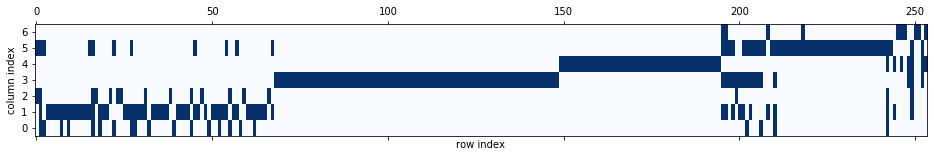

In [12]:
plt.matshow(data_mi.values.T, cmap=plt.cm.Blues, aspect="auto", origin="lower")
plt.xlabel("row index")
plt.ylabel("column index")
plt.show()
# I plotted the transpose so it doesn't give us a long image

## Brief Analysis
Let's take a look and see where the actual Loyal Nine members ended up. The organization ended up in our `Cluster 5`, but how many members of that bicluster match?

Loyal Nine [members](https://books.google.com/books?id=iNgNCgAAQBAJ&pg=PA26#v=onepage&q&f=false
):

- John Avery, a distiller and club secretary;
- John Smith and Stephen Cleverly, both braziers;
- Thomas Crafts, a printer;
- Benjamin Edes, who along with John Gill produced the important Boston Gazette;
- Thomas Chase, a distiller;
- Joseph Field, a ship's captain;
- George Trott, a jeweler;
- Henry Bass, a merchant related to Samuel Adams

In [13]:
loyal_nine = [
    "Avery, John",
    "Smith, John",
    "Cleverly, Stephen",
    "Crafts, Thomas",
    "Edes, Benjamin",
    "Chase, Thomas",
    "Field, Joseph",
    "Trott, George",
    "Bass, Henry",
]

In [14]:
data_mi[data_mi.index.get_level_values("person").isin(loyal_nine)]

cluster                                 0                                   1  \
org                       BostonCommittee LondonEnemies LongRoomClub TeaParty   
cluster person                                                                  
3       Bass, Henry                     0             1            0        1   
        Chase, Thomas                   0             1            0        1   
4       Avery, John                     0             1            0        0   
        Edes, Benjamin                  0             0            0        0   
5       Cleverly, Stephen               0             0            0        0   
        Crafts, Thomas                  0             0            0        0   
        Field, Joseph                   0             0            0        0   
        Smith, John                     0             0            0        0   
        Trott, George                   0             0            0        0   

cluster                                2           4         5  
org                       StAndrewsLodge NorthCaucus LoyalNine  
cluster person                                                  
3       Bass, Henry                    0           1         1  
        Chase, Thomas                  0           1         1  
4       Avery, John                    0           0         1  
        Edes, Benjamin                 0           1         1  
5       Cleverly, Stephen              0           0         1  
        Crafts, Thomas                 1           0         1  
        Field, Joseph                  0           0         1  
        Smith, John                    0           0         1  
        Trott, George                  0           0         1

In `Cluster 5` we recovered all individuals who were *exclusively* members of the Loyal Nine, plus Thomas Crafts. `Cluster 4` pulled two Loyal Nine members also part of the North Caucus and London Enemies, and `Cluster 3` holds members that were additionally part of the North Cacus, Tea Party, and London Enemies each. Also note Cluster 3 contains no organizations -- it's members are part of several organizations.

## Export to Excel
It's helpful to export this to Excel because the MultiIndex formats nicely into merged cells and retains the hierarchical indexing structure.

The data is on the `data` sheet, and cluster details are on the `clusters` sheet.

In [15]:
data_sheets = [(data_mi, "data"), (cluster_info, "clusters")]

filename = "bicluster.xlsx"
writer = pd.ExcelWriter(filename, engine="xlsxwriter")
for data in data_sheets:
    data[0].to_excel(writer, sheet_name=data[1])
writer.save()